# Simple Multi AI Agent

In [49]:
import os 
from typing import TypedDict, Annotated, List, Literal
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain_openai import AzureChatOpenAI
from langchain_core.tools import tool 
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph,END 
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_groq import ChatGroq
from dotenv import load_dotenv
load_dotenv()

True

In [50]:
llm_open_ai=AzureChatOpenAI(
    azure_deployment='gpt-4o',
    api_key=os.getenv('AZURE_OPENAI_GPT_4O_API_KEY'),
    azure_endpoint=os.getenv('AZURE_OPENAI_GPT_4O_API_ENDPOINT'),
    api_version=os.getenv('AZURE_OPENAI_GPT_4O_API_VERSION')
)

llm_groq=ChatGroq(model='deepseek-r1-distill-llama-70b',api_key=os.getenv('GROQ_API'))


In [51]:
from langgraph.graph import StateGraph, END, MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver 

In [52]:
## Define the state 
class AgentState(MessagesState):
    next_agent:str # which agent should go next 

In [53]:
# create simple tools 
@tool 
def search_web(query:str)->str:
    """ 
    Search the web for information
    """
    search=TavilySearchResults(max_results=3)
    results=search.invoke(query)
    return results

@tool
def write_summary(content:str)-> str:
    """ 
    write a summary of the provided context.
    """
    # simple summary generation 
    summary=f'Summary of findings:\n\n{content[:500]}...'
    return summary


In [54]:
 # define agent functions (simple approach)
def researcher_agent(state:AgentState):
    """ 
    Researcher agent that searches for information 
    """
    messages =state['messages']

    # Add system message for contexxt 
    system_msg=SystemMessage(content="You are a research assistant. Use the serach_web tool to find information about the user's request")

    # call LLM with tools 
    researcher_llm=llm_open_ai.bind_tools([search_web])
    response=researcher_llm.invoke([system_msg]+messages)
    print(response)
    # return the response and route to writer 
    return {
        "messages":[response],
        "next_agent":"writer"
    }

In [55]:
# define write agent 
def writer_agent(state:AgentState):
    """ 
    writer agent that creates summaries
    """
    messages=state['messages']

    # Add system message 
    system_msg=SystemMessage(content='you are a technical writer. Review the conversation and create a clear, concise summary of the findings')

    # Simple completion without tools 
    response=llm_open_ai.invoke([system_msg]+messages)
    # print(messages)
    return {
        "messages":[response],
        "next_agent":"end"
    }



In [56]:
def execute_tools(state: AgentState):
    """ 
    Execute any pending tool calls 
    """
    messages=state['messages']
    last_messages=messages[-1]

    # Check if there are tool calls to execute 
    if hasattr(last_messages, "tool_calls") and last_messages.tool_calls:
        # create tool node and execute 
        tool_node=ToolNode([search_web, write_summary])
        response=tool_node.invoke(state)
        return response
    
    # No tools to execute 
    return state

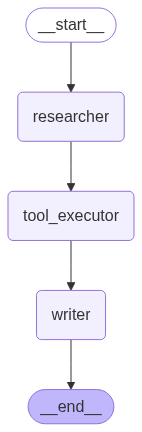

In [58]:
# build graph
workflow=StateGraph(AgentState)

# Add nodes 
workflow.add_node('researcher',researcher_agent)
workflow.add_node('writer',writer_agent)
workflow.add_node('tool_executor',ToolNode([search_web,write_summary]))

# Define flow 
workflow.set_entry_point('researcher')
workflow.add_edge('researcher','tool_executor')
workflow.add_edge('tool_executor','writer')
workflow.add_edge('writer',END)
final_workflow=workflow.compile()
final_workflow

In [60]:
response=final_workflow.invoke({'messages':"Research about the use case of agentic AI in business"})
print(response['messages'][-1].content)

content='' additional_kwargs={'tool_calls': [{'id': 'call_XdIYWdzXJqBdl6xbpNPFiO42', 'function': {'arguments': '{"query":"use cases of agentic AI in business"}', 'name': 'search_web'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 74, 'total_tokens': 96, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-BtEXfoM5YGbgsnaeMjXQVSEV28PAf', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': '